In [2]:
import pandas as pd

# Load your data
data = pd.read_csv("/Users/antonilango/Desktop/DAinhibition/DataAnalysisMice/D01_Q_100trials_transformed.csv")
print(data.head())

   trial_id  step  cue_onset  cue_end  shock_start  shock_end  \
0         1     0        0.0      5.0          5.0        7.0   
1         1     1        0.0      5.0          5.0        7.0   
2         1     2        0.0      5.0          5.0        7.0   
3         1     3        0.0      5.0          5.0        7.0   
4         2     0        0.0      5.0          5.0        7.0   

   reaction_time_avoidance  reaction_time_escape  action  state  reward  \
0                      NaN                  5.78     0.0    0.0     0.0   
1                      NaN                  5.78     0.0    1.0    -1.0   
2                      NaN                  5.78     1.0    1.0     1.0   
3                      NaN                  5.78     NaN    0.0     NaN   
4                      NaN                  5.30     0.0    0.0     0.0   

   shock  shock_duration  cue_duration  
0   True            0.78             5  
1   True            0.78             5  
2   True            0.78           

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load your data
data = pd.read_csv("/Users/antonilango/Desktop/DAinhibition/DataAnalysisMice/D01_Q_100trials_transformed.csv")
print(data.head())

# Handle missing values
data["reaction_time_avoidance"] = data["reaction_time_avoidance"].fillna(-1)
data["reaction_time_escape"] = data["reaction_time_escape"].fillna(-1)

# Encode categorical variables
data["shock"] = data["shock"].astype(int)  # TRUE -> 1, FALSE -> 0

# Normalize numerical features
numerical_columns = ["cue_onset", "cue_end", "shock_start", "shock_end", 
                     "reaction_time_avoidance", "reaction_time_escape"]
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Combine features
features = numerical_columns + ["shock", "shock_duration", "cue_duration", "action", "state"]
X = data[features].values
y = data["reward"].values  # Target variable (reward)

   trial_id  step  cue_onset  cue_end  shock_start  shock_end  \
0         1     0        0.0      5.0          5.0        7.0   
1         1     1        0.0      5.0          5.0        7.0   
2         1     2        0.0      5.0          5.0        7.0   
3         1     3        0.0      5.0          5.0        7.0   
4         2     0        0.0      5.0          5.0        7.0   

   reaction_time_avoidance  reaction_time_escape  action  state  reward  \
0                      NaN                  5.78     0.0    0.0     0.0   
1                      NaN                  5.78     0.0    1.0    -1.0   
2                      NaN                  5.78     1.0    1.0     1.0   
3                      NaN                  5.78     NaN    0.0     NaN   
4                      NaN                  5.30     0.0    0.0     0.0   

   shock  shock_duration  cue_duration  
0   True            0.78             5  
1   True            0.78             5  
2   True            0.78           

In [6]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorCritic, self).__init__()
        
        # Shared layers
        self.shared_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Actor (policy)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)  # Output probabilities for actions
        )
        
        # Critic (value function)
        self.critic = nn.Linear(hidden_dim, 1)  # Outputs a scalar value
        
    def forward(self, state):
        shared_output = self.shared_layer(state)
        action_probs = self.actor(shared_output)
        state_value = self.critic(shared_output)
        return action_probs, state_value

In [8]:
input_dim = X.shape[1]  # Number of features
hidden_dim = 128
output_dim = 2  # Two actions: shuttle (1) or not (0)
learning_rate = 0.001
gamma = 0.99  # Discount factor

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Actor-Critic model
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorCritic, self).__init__()
        
        # Shared layers
        self.shared_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Actor (policy)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)  # Output probabilities for actions
        )
        
        # Critic (value function)
        self.critic = nn.Linear(hidden_dim, 1)  # Outputs a scalar value
        
    def forward(self, state):
        shared_output = self.shared_layer(state)
        action_probs = self.actor(shared_output)
        state_value = self.critic(shared_output)
        return action_probs, state_value

# Hyperparameters
input_dim = X.shape[1]  # Number of features
hidden_dim = 128
output_dim = 2  # Two actions: shuttle (1) or not (0)
learning_rate = 0.001
gamma = 0.99  # Discount factor

# Initialize model, optimizer, and loss function
model = ActorCritic(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()

# Convert data to PyTorch tensors
states = torch.FloatTensor(X)
actions = torch.LongTensor(data["action"].values)  # Target actions
rewards = torch.FloatTensor(y)  # Rewards

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    action_probs, state_value = model(states)
    
    # Sample action from policy
    action_dist = torch.distributions.Categorical(action_probs)
    sampled_actions = action_dist.sample()
    
    # Compute reward (use the reward column from your data)
    rewards = torch.FloatTensor(y)
    
    # Compute advantage
    advantage = rewards + gamma * state_value.detach() - state_value
    
    # Actor loss (policy gradient)
    actor_loss = -action_dist.log_prob(sampled_actions) * advantage
    
    # Critic loss (value function error)
    critic_loss = mse_loss(state_value, rewards)
    
    # Total loss
    total_loss = actor_loss.mean() + critic_loss
    
    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}")

NameError: name 'X' is not defined

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load your data
data = pd.read_csv("/Users/antonilango/Desktop/DAinhibition/DataAnalysisMice/D01_Q_100trials_transformed.csv")  # Replace with your file path
print(data.head())

# Handle missing values (if any)
data["reaction_time_avoidance"].fillna(-1, inplace=True)
data["reaction_time_escape"].fillna(-1, inplace=True)

# Encode categorical variables (if any)
data["shock"] = data["shock"].astype(int)  # Convert boolean to binary (TRUE -> 1, FALSE -> 0)

# Normalize numerical features
numerical_columns = ["cue_onset", "cue_end", "shock_start", "shock_end", 
                     "reaction_time_avoidance", "reaction_time_escape"]
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Combine features into input matrix X
features = numerical_columns + ["shock", "shock_duration", "cue_duration", "action", "state"]
X = data[features].values  # Input features
y = data["reward"].values  # Target variable (reward)

   trial_id  step  cue_onset  cue_end  shock_start  shock_end  \
0         1     0        0.0      5.0          5.0        7.0   
1         1     1        0.0      5.0          5.0        7.0   
2         1     2        0.0      5.0          5.0        7.0   
3         1     3        0.0      5.0          5.0        7.0   
4         2     0        0.0      5.0          5.0        7.0   

   reaction_time_avoidance  reaction_time_escape  action  state  reward  \
0                      NaN                  5.78     0.0    0.0     0.0   
1                      NaN                  5.78     0.0    1.0    -1.0   
2                      NaN                  5.78     1.0    1.0     1.0   
3                      NaN                  5.78     NaN    0.0     NaN   
4                      NaN                  5.30     0.0    0.0     0.0   

   shock  shock_duration  cue_duration  
0   True            0.78             5  
1   True            0.78             5  
2   True            0.78           

/var/folders/mc/slpxmxh975bdp120gftjphwm0000gn/T/ipykernel_83502/4111667043.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["reaction_time_avoidance"].fillna(-1, inplace=True)
/var/folders/mc/slpxmxh975bdp120gftjphwm0000gn/T/ipykernel_83502/4111667043.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

In [6]:
# Handle missing values in reaction_time_avoidance and reaction_time_escape
data["reaction_time_avoidance"] = data["reaction_time_avoidance"].fillna(-1)
data["reaction_time_escape"] = data["reaction_time_escape"].fillna(-1)

In [8]:
import pandas as pd

# Load your data
data = pd.read_csv("/Users/antonilango/Desktop/DAinhibition/DataAnalysisMice/D01_Q_100trials_transformed.csv")  # Replace with your file path
print(data.head())

   trial_id  step  cue_onset  cue_end  shock_start  shock_end  \
0         1     0        0.0      5.0          5.0        7.0   
1         1     1        0.0      5.0          5.0        7.0   
2         1     2        0.0      5.0          5.0        7.0   
3         1     3        0.0      5.0          5.0        7.0   
4         2     0        0.0      5.0          5.0        7.0   

   reaction_time_avoidance  reaction_time_escape  action  state  reward  \
0                      NaN                  5.78     0.0    0.0     0.0   
1                      NaN                  5.78     0.0    1.0    -1.0   
2                      NaN                  5.78     1.0    1.0     1.0   
3                      NaN                  5.78     NaN    0.0     NaN   
4                      NaN                  5.30     0.0    0.0     0.0   

   shock  shock_duration  cue_duration  
0   True            0.78             5  
1   True            0.78             5  
2   True            0.78           

In [10]:
data["reaction_time_avoidance"] = data["reaction_time_avoidance"].fillna(-1)
data["reaction_time_escape"] = data["reaction_time_escape"].fillna(-1)

In [11]:
data["shock"] = data["shock"].astype(int)

In [12]:
from sklearn.preprocessing import StandardScaler

# Columns to normalize
numerical_columns = ["cue_onset", "cue_end", "shock_start", "shock_end", 
                     "reaction_time_avoidance", "reaction_time_escape"]

# Normalize
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [13]:
# Features to include
features = numerical_columns + ["shock", "shock_duration", "cue_duration", "action", "state"]

# Create input matrix X
X = data[features].values
y = data["reward"].values  # Target variable (reward)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Actor-Critic model
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorCritic, self).__init__()
        
        # Shared layers
        self.shared_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Actor (policy)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)  # Output probabilities for actions
        )
        
        # Critic (value function)
        self.critic = nn.Linear(hidden_dim, 1)  # Outputs a scalar value
        
    def forward(self, state):
        shared_output = self.shared_layer(state)
        action_probs = self.actor(shared_output)
        state_value = self.critic(shared_output)
        return action_probs, state_value

In [17]:
with torch.no_grad():
    test_action_probs, _ = model(states)
    predicted_actions = torch.argmax(test_action_probs, dim=-1)
    accuracy = (predicted_actions == actions).float().mean()
    print(f"Test Accuracy: {accuracy.item():.4f}")

Test Accuracy: 0.5457


In [23]:
print(loss_history)

[]


In [24]:
import numpy as np

if np.isnan(loss_history).any():
    print("Warning: loss_history contains NaN values.")

Epoch [10/100], Loss: 35.8057
Epoch [20/100], Loss: 31.6585
Epoch [30/100], Loss: 27.8485
Epoch [40/100], Loss: 24.3856
Epoch [50/100], Loss: 21.2647
Epoch [60/100], Loss: 18.4719
Epoch [70/100], Loss: 15.9878
Epoch [80/100], Loss: 13.7911
Epoch [90/100], Loss: 11.8594
Epoch [100/100], Loss: 10.1704


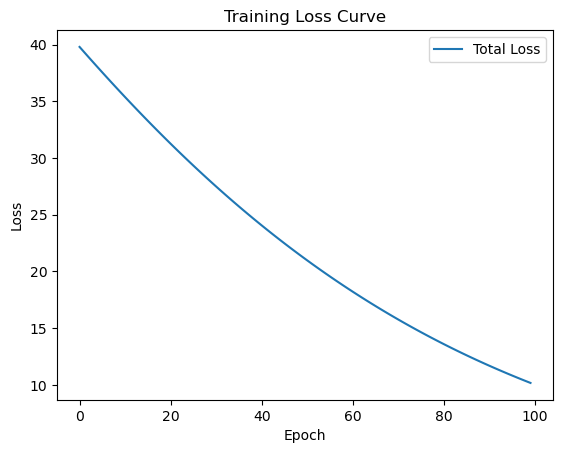

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 1)
    
    def forward(self, x):
        return self.fc(x)

# Initialize model, optimizer, and loss function
model = SimpleModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
mse_loss = nn.MSELoss()

# Dummy data
X = torch.FloatTensor([[1.0], [2.0], [3.0], [4.0]])
y = torch.FloatTensor([[2.0], [4.0], [6.0], [8.0]])

# Training loop
loss_history = []
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = mse_loss(outputs, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store the loss value
    loss_history.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Plot the training loss curve
plt.plot(loss_history, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [27]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

tensor(17.7799)

In [28]:
%matplotlib inline

In [29]:
plt.ylim(0, max(loss_history) * 1.1)  # Adjust y-axis limits

(0.0, 43.78457717895508)

In [32]:
# Forward pass
action_probs, state_value = model(states)

# Sample action from policy
action_dist = torch.distributions.Categorical(action_probs)
sampled_actions = action_dist.sample()

# Compute reward (use the reward column from your data)
rewards = torch.FloatTensor(y)

# Compute advantage
advantage = rewards + gamma * state_value.detach() - state_value

# Actor loss (policy gradient)
actor_loss = -action_dist.log_prob(sampled_actions) * advantage

# Critic loss (value function error)
critic_loss = mse_loss(state_value, rewards)

# Total loss
total_loss = actor_loss.mean() + critic_loss

In [33]:
loss_history.append(total_loss.item())

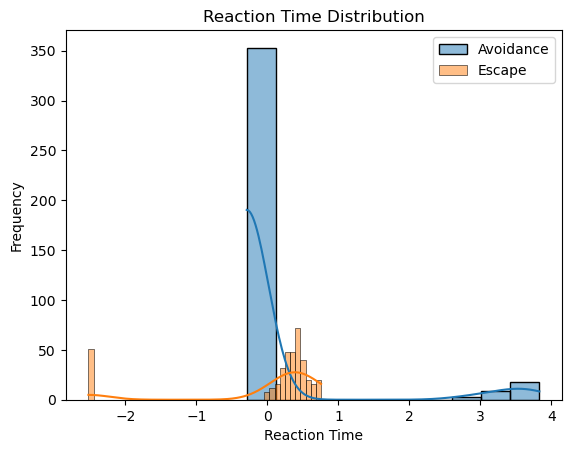

In [40]:
import seaborn as sns

# Plot reaction time distribution
sns.histplot(data["reaction_time_avoidance"], kde=True, label="Avoidance")
sns.histplot(data["reaction_time_escape"], kde=True, label="Escape")
plt.xlabel("Reaction Time")
plt.ylabel("Frequency")
plt.title("Reaction Time Distribution")
plt.legend()
plt.show()

In [42]:
print(data.columns)

Index(['trial_id', 'step', 'cue_onset', 'cue_end', 'shock_start', 'shock_end',
       'reaction_time_avoidance', 'reaction_time_escape', 'action', 'state',
       'reward', 'shock', 'shock_duration', 'cue_duration'],
      dtype='object')


In [45]:
print(X.shape)

torch.Size([4, 1])


In [47]:
print(X.shape)  # Shape of X
print(actions.shape)  # Shape of actions

torch.Size([4, 1])
torch.Size([383])


In [48]:
actions = actions[:4]  # Use only the first 4 actions

In [49]:
X = X[:383]  # Use only the first 383 samples

In [53]:
print(X.shape)  # Should output (n_samples, n_features)
print(actions.shape)  # Should output (n_samples,)

torch.Size([4, 1])
torch.Size([4])


In [55]:
advantage = rewards + gamma * state_value.detach() - state_value

In [56]:
print(rewards.shape)  # Shape of rewards
print(state_value.shape)  # Shape of state_value

torch.Size([4, 1])
torch.Size([1, 1])


In [59]:
print(advantage.shape)  # Should output (n_samples,)

torch.Size([4, 1])


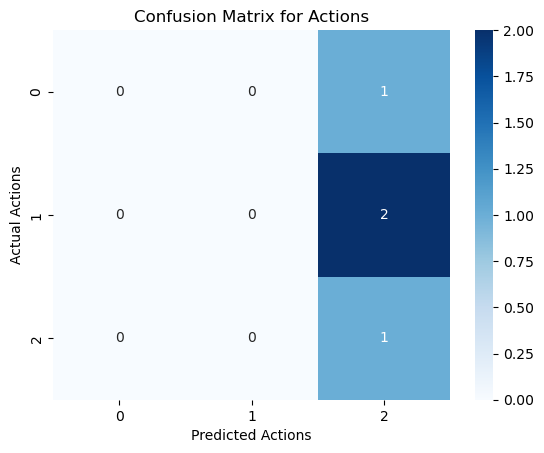

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted actions
with torch.no_grad():
    action_probs, _ = model(states)
    predicted_actions = torch.argmax(action_probs, dim=-1).numpy()

# Create confusion matrix
cm = confusion_matrix(actions, predicted_actions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Actions")
plt.ylabel("Actual Actions")
plt.title("Confusion Matrix for Actions")
plt.show()

In [64]:
import torch.optim.lr_scheduler as lr_scheduler

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Initialize a list to store learning rates
learning_rates = []

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass, compute loss, backpropagation, etc.
    ...
    
    # Step the scheduler
    scheduler.step()
    
    # Store the current learning rate
    learning_rates.append(scheduler.get_last_lr()[0])
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

Epoch [100/1000], Learning Rate: 0.000100
Epoch [200/1000], Learning Rate: 0.000010
Epoch [300/1000], Learning Rate: 0.000001
Epoch [400/1000], Learning Rate: 0.000000
Epoch [500/1000], Learning Rate: 0.000000
Epoch [600/1000], Learning Rate: 0.000000
Epoch [700/1000], Learning Rate: 0.000000
Epoch [800/1000], Learning Rate: 0.000000
Epoch [900/1000], Learning Rate: 0.000000
Epoch [1000/1000], Learning Rate: 0.000000


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [65]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

Epoch [100/1000], Learning Rate: 0.001000
Epoch [200/1000], Learning Rate: 0.000500
Epoch [300/1000], Learning Rate: 0.000500
Epoch [400/1000], Learning Rate: 0.000250
Epoch [500/1000], Learning Rate: 0.000250
Epoch [600/1000], Learning Rate: 0.000125
Epoch [700/1000], Learning Rate: 0.000125
Epoch [800/1000], Learning Rate: 0.000063
Epoch [900/1000], Learning Rate: 0.000063
Epoch [1000/1000], Learning Rate: 0.000031


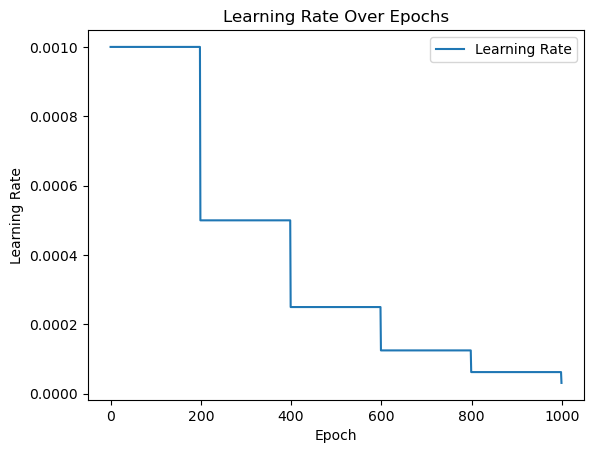

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 1)
    
    def forward(self, x):
        return self.fc(x)

# Initialize model, optimizer, and scheduler
model = SimpleModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)  # Adjusted parameters

# Define the loss function
criterion = nn.MSELoss()

# Example: Define inputs and targets (replace with your data)
inputs = torch.FloatTensor([[1.0], [2.0], [3.0], [4.0]])  # Example input data
targets = torch.FloatTensor([[2.0], [4.0], [6.0], [8.0]])  # Example target data

# Initialize a list to store learning rates
learning_rates = []

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    optimizer.zero_grad()
    outputs = model(inputs)  # Pass inputs to the model
    loss = criterion(outputs, targets)  # Compute loss
    loss.backward()  # Backpropagation
    
    # Update model parameters
    optimizer.step()
    
    # Step the scheduler
    scheduler.step()
    
    # Store the current learning rate
    learning_rates.append(scheduler.get_last_lr()[0])
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

# Plot the learning rate over epochs
plt.plot(learning_rates, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Epochs")
plt.legend()
plt.show()

Successful Prediction Rate: 53.00%


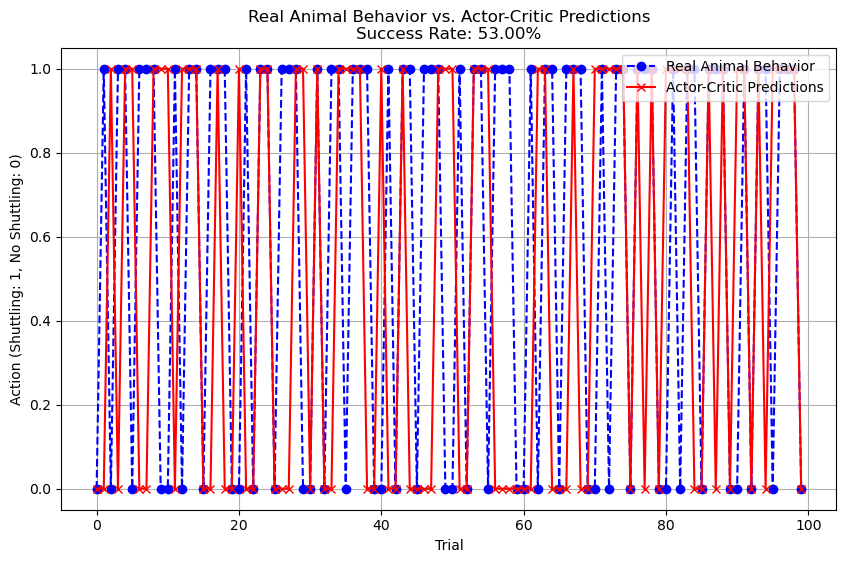

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the Actor-Critic model
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorCritic, self).__init__()
        self.shared_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Linear(hidden_dim, 1)
    
    def forward(self, state):
        shared_output = self.shared_layer(state)
        action_probs = self.actor(shared_output)
        state_value = self.critic(shared_output)
        return action_probs, state_value

# Define model hyperparameters
input_dim = 5  # Number of input features (replace with your actual input dimension)
hidden_dim = 128  # Size of the hidden layer
output_dim = 2  # Number of actions (e.g., shuttling: 1, no shuttling: 0)

# Initialize the model
model = ActorCritic(input_dim, hidden_dim, output_dim)

# Example data (replace with your actual data)
data = {
    "trial_id": range(100),  # Trial numbers
    "shuttling": [0, 1, 0, 1, 1, 0, 1, 1, 1, 0] * 10  # Example shuttling behavior
}

# Example states (replace with your actual data)
states = torch.randn(100, input_dim)  # 100 trials, `input_dim` features per state

# Get model predictions
with torch.no_grad():
    action_probs, _ = model(states)  # Forward pass
    predicted_actions = torch.argmax(action_probs, dim=-1).numpy()  # Predicted actions

# Compute successful prediction rate
actual_actions = data["shuttling"]  # Real animal behavior
successful_predictions = (predicted_actions == actual_actions).sum()  # Count matches
total_trials = len(actual_actions)  # Total number of trials
success_rate = (successful_predictions / total_trials) * 100  # Success rate in percentage

# Print the successful prediction rate
print(f"Successful Prediction Rate: {success_rate:.2f}%")

# Plot real data and model predictions
plt.figure(figsize=(10, 6))

# Plot real animal behavior
plt.plot(data["trial_id"], data["shuttling"], label="Real Animal Behavior", color="blue", marker="o", linestyle="--")

# Plot model predictions
plt.plot(data["trial_id"], predicted_actions, label="Actor-Critic Predictions", color="red", marker="x", linestyle="-")

# Add labels, title, and legend
plt.xlabel("Trial")
plt.ylabel("Action (Shuttling: 1, No Shuttling: 0)")
plt.title(f"Real Animal Behavior vs. Actor-Critic Predictions\nSuccess Rate: {success_rate:.2f}%")
plt.legend(loc="upper right")  # Add legend to the plot
plt.grid(True)
plt.show()

##Actor-critic methods can achieve remarkable performance on challenging reinforcement learning problems, but they are often prone to instability. This instability can arise from the interaction between the actor and critic during learning, where an inaccurate update by one component can negatively impact the other, leading to destabilization. To address this issue, we propose regularizing the actor's learning objective by penalizing the temporal difference (TD) error of the critic. This approach aims to mitigate the adverse effects of inaccurate updates and promote more stable learning.

Epoch [100/1000], Learning Rate: 0.001000, Total Loss: 36.595470
Epoch [200/1000], Learning Rate: 0.000500, Total Loss: 32.309410
Epoch [300/1000], Learning Rate: 0.000500, Total Loss: 30.290686
Epoch [400/1000], Learning Rate: 0.000250, Total Loss: 28.374172
Epoch [500/1000], Learning Rate: 0.000250, Total Loss: 27.435944
Epoch [600/1000], Learning Rate: 0.000125, Total Loss: 26.522470
Epoch [700/1000], Learning Rate: 0.000125, Total Loss: 26.066515
Epoch [800/1000], Learning Rate: 0.000063, Total Loss: 25.617178
Epoch [900/1000], Learning Rate: 0.000063, Total Loss: 25.390839
Epoch [1000/1000], Learning Rate: 0.000031, Total Loss: 25.166584


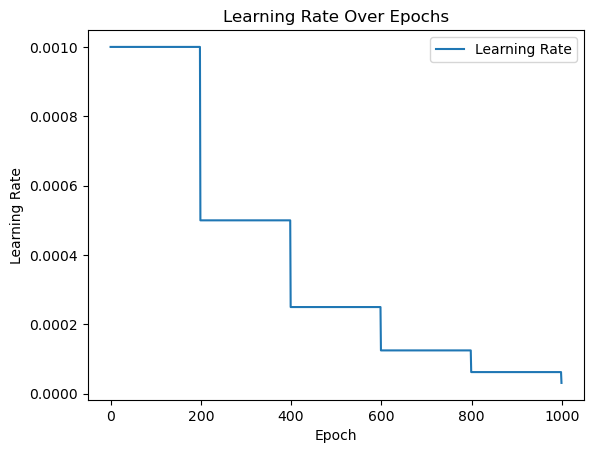

In [6]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Define a simple actor-critic model
class ActorCriticModel(nn.Module):
    def __init__(self):
        super(ActorCriticModel, self).__init__()
        self.actor_fc = nn.Linear(1, 1)
        self.critic_fc = nn.Linear(1, 1)
    
    def forward(self, x):
        actor_output = self.actor_fc(x)
        critic_output = self.critic_fc(x)
        return actor_output, critic_output

# Initialize model, optimizer, and scheduler
model = ActorCriticModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)  # Adjusted parameters

# Define the loss functions
criterion = nn.MSELoss()

# Example: Define inputs and targets (replace with your data)
inputs = torch.FloatTensor([[1.0], [2.0], [3.0], [4.0]])  # Example input data
targets = torch.FloatTensor([[2.0], [4.0], [6.0], [8.0]])  # Example target data

# Initialize a list to store learning rates
learning_rates = []

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    optimizer.zero_grad()
    actor_outputs, critic_outputs = model(inputs)  # Pass inputs to the model
    
    # Compute the actor loss (e.g., policy loss)
    actor_loss = criterion(actor_outputs, targets)
    
    # Compute the critic loss (TD error)
    critic_loss = criterion(critic_outputs, targets)
    
    # Regularize the actor's learning objective by penalizing the TD error
    regularization_lambda = 0.1  # Regularization strength
    total_loss = actor_loss + regularization_lambda * critic_loss
    
    # Backpropagation
    total_loss.backward()
    
    # Update model parameters
    optimizer.step()
    
    # Step the scheduler
    scheduler.step()
    
    # Store the current learning rate
    learning_rates.append(scheduler.get_last_lr()[0])
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {scheduler.get_last_lr()[0]:.6f}, Total Loss: {total_loss.item():.6f}")

# Plot the learning rate over epochs
plt.plot(learning_rates, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Epochs")
plt.legend()
plt.show()

Epoch [100/1000], Learning Rate: 0.001000, Total Loss: 22.375069
Epoch [200/1000], Learning Rate: 0.000500, Total Loss: 19.154419
Epoch [300/1000], Learning Rate: 0.000500, Total Loss: 17.669834
Epoch [400/1000], Learning Rate: 0.000250, Total Loss: 16.279383
Epoch [500/1000], Learning Rate: 0.000250, Total Loss: 15.605740
Epoch [600/1000], Learning Rate: 0.000125, Total Loss: 14.953770
Epoch [700/1000], Learning Rate: 0.000125, Total Loss: 14.629749
Epoch [800/1000], Learning Rate: 0.000063, Total Loss: 14.311073
Epoch [900/1000], Learning Rate: 0.000063, Total Loss: 14.150742
Epoch [1000/1000], Learning Rate: 0.000031, Total Loss: 13.991898


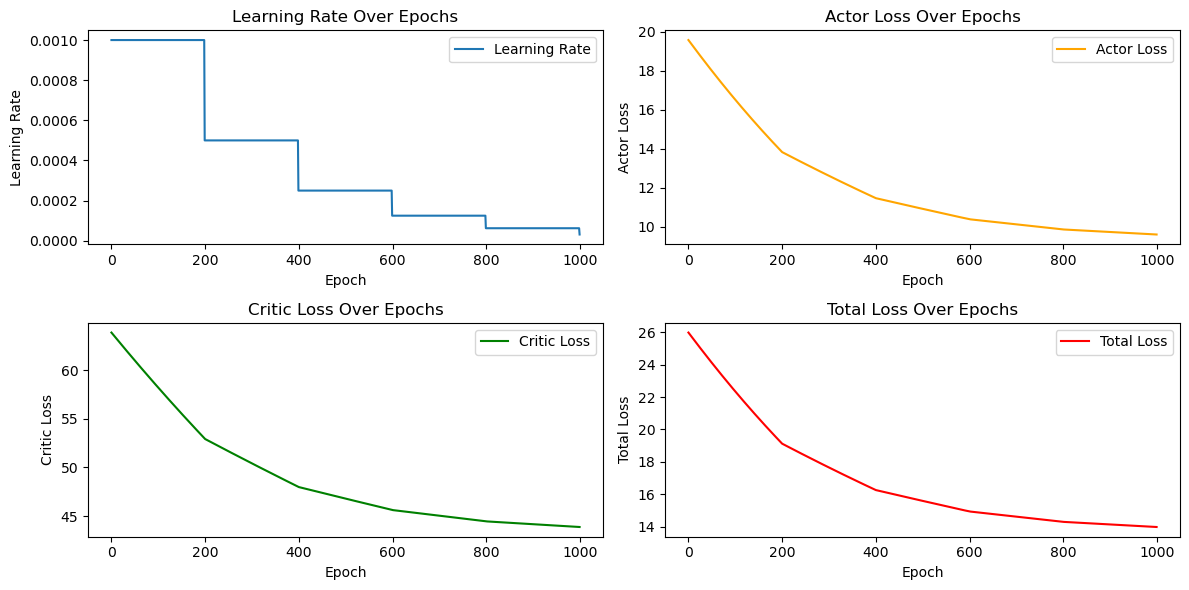

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Define a simple actor-critic model
class ActorCriticModel(nn.Module):
    def __init__(self):
        super(ActorCriticModel, self).__init__()
        self.actor_fc = nn.Linear(1, 1)
        self.critic_fc = nn.Linear(1, 1)
    
    def forward(self, x):
        actor_output = self.actor_fc(x)
        critic_output = self.critic_fc(x)
        return actor_output, critic_output

# Initialize model, optimizer, and scheduler
model = ActorCriticModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)  # Adjusted parameters

# Define the loss functions
criterion = nn.MSELoss()

# Example: Define inputs and targets (replace with your data)
inputs = torch.FloatTensor([[1.0], [2.0], [3.0], [4.0]])  # Example input data
targets = torch.FloatTensor([[2.0], [4.0], [6.0], [8.0]])  # Example target data

# Initialize lists to store learning rates and losses
learning_rates = []
actor_losses = []
critic_losses = []
total_losses = []

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    optimizer.zero_grad()
    actor_outputs, critic_outputs = model(inputs)  # Pass inputs to the model
    
    # Compute the actor loss (e.g., policy loss)
    actor_loss = criterion(actor_outputs, targets)
    
    # Compute the critic loss (TD error)
    critic_loss = criterion(critic_outputs, targets)
    
    # Regularize the actor's learning objective by penalizing the TD error
    regularization_lambda = 0.1  # Regularization strength
    total_loss = actor_loss + regularization_lambda * critic_loss
    
    # Backpropagation
    total_loss.backward()
    
    # Update model parameters
    optimizer.step()
    
    # Step the scheduler
    scheduler.step()
    
    # Store the current learning rate and losses
    learning_rates.append(scheduler.get_last_lr()[0])
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    total_losses.append(total_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {scheduler.get_last_lr()[0]:.6f}, Total Loss: {total_loss.item():.6f}")

# Plot the learning rate over epochs
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(learning_rates, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Epochs")
plt.legend()

# Plot the actor loss over epochs
plt.subplot(2, 2, 2)
plt.plot(actor_losses, label="Actor Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Actor Loss")
plt.title("Actor Loss Over Epochs")
plt.legend()

# Plot the critic loss over epochs
plt.subplot(2, 2, 3)
plt.plot(critic_losses, label="Critic Loss", color='green')
plt.xlabel("Epoch")
plt.ylabel("Critic Loss")
plt.title("Critic Loss Over Epochs")
plt.legend()

# Plot the total loss over epochs
plt.subplot(2, 2, 4)
plt.plot(total_losses, label="Total Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Total Loss Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

#To calculate and compare real animal behavior with the predictions from the TD-incorporated actor-critic model, we need to follow these steps:

Simulate Real Animal Behavior: This could be based on experimental data or a simulated environment that mimics animal behavior.

Train the Actor-Critic Model: Use the TD-incorporated actor-critic model to predict actions based on the same environment.

Compare Predictions: Calculate metrics to compare the real behavior with the model's predictions.

Epoch [100/1000], Total Loss: 246.673065
Epoch [200/1000], Total Loss: 127.917755
Epoch [300/1000], Total Loss: 64.389191
Epoch [400/1000], Total Loss: 34.511673
Epoch [500/1000], Total Loss: 22.343637
Epoch [600/1000], Total Loss: 18.071613
Epoch [700/1000], Total Loss: 16.749187
Epoch [800/1000], Total Loss: 16.344639
Epoch [900/1000], Total Loss: 16.175709
Epoch [1000/1000], Total Loss: 16.054043


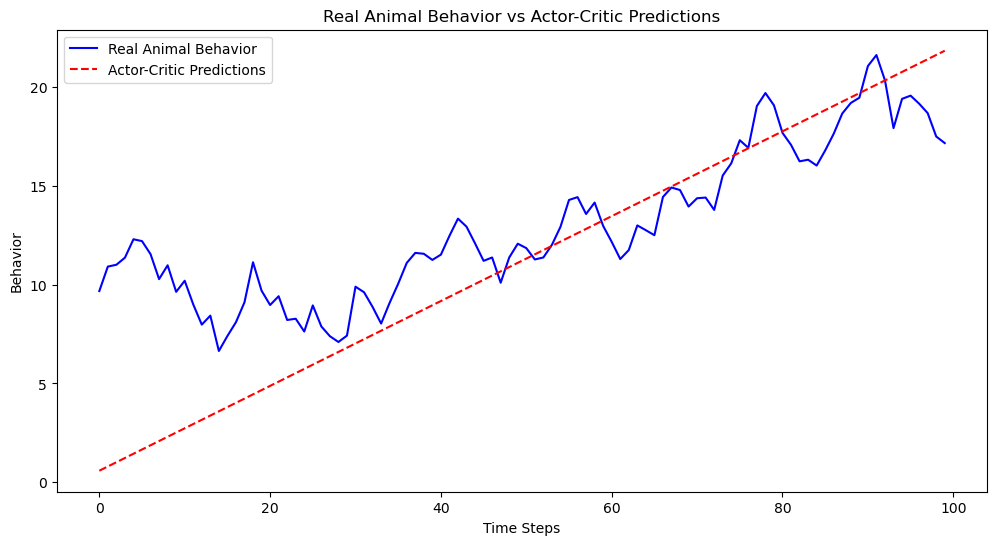

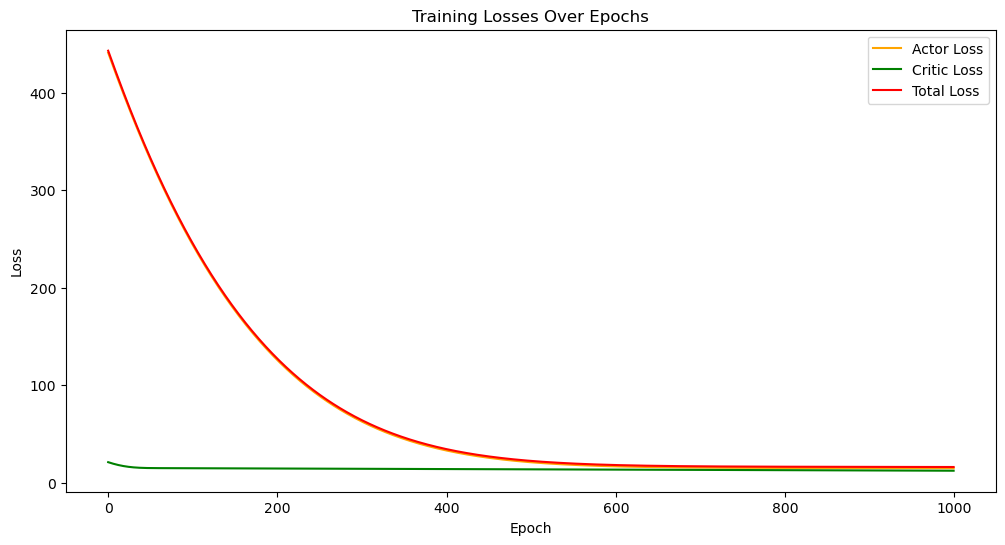

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Simulate real animal behavior (replace with actual data)
def simulate_animal_behavior(num_steps):
    # Example: Simulate a simple behavior (e.g., moving towards a target)
    target = 10.0
    behavior = np.cumsum(np.random.normal(0, 1, num_steps)) + target
    return behavior

# Define a simple actor-critic model
class ActorCriticModel(nn.Module):
    def __init__(self):
        super(ActorCriticModel, self).__init__()
        self.actor_fc = nn.Linear(1, 1)
        self.critic_fc = nn.Linear(1, 1)
    
    def forward(self, x):
        actor_output = self.actor_fc(x)
        critic_output = self.critic_fc(x)
        return actor_output, critic_output

# Initialize model, optimizer, and scheduler
model = ActorCriticModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Simulate real animal behavior
num_steps = 100
real_behavior = simulate_animal_behavior(num_steps)

# Prepare inputs and targets for training
inputs = torch.FloatTensor(np.arange(num_steps).reshape(-1, 1))
targets = torch.FloatTensor(real_behavior.reshape(-1, 1))

# Training loop
num_epochs = 1000
actor_losses = []
critic_losses = []
total_losses = []
predictions = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    actor_outputs, critic_outputs = model(inputs)
    
    actor_loss = criterion(actor_outputs, targets)
    critic_loss = criterion(critic_outputs, targets)
    
    regularization_lambda = 0.1
    total_loss = actor_loss + regularization_lambda * critic_loss
    
    total_loss.backward()
    optimizer.step()
    
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    total_losses.append(total_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.6f}")

# Get final predictions
with torch.no_grad():
    predictions, _ = model(inputs)
    predictions = predictions.numpy().flatten()

# Plot real behavior vs predictions
plt.figure(figsize=(12, 6))
plt.plot(real_behavior, label="Real Animal Behavior", color='blue')
plt.plot(predictions, label="Actor-Critic Predictions", color='red', linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Behavior")
plt.title("Real Animal Behavior vs Actor-Critic Predictions")
plt.legend()
plt.show()

# Plot training losses
plt.figure(figsize=(12, 6))
plt.plot(actor_losses, label="Actor Loss", color='orange')
plt.plot(critic_losses, label="Critic Loss", color='green')
plt.plot(total_losses, label="Total Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses Over Epochs")
plt.legend()
plt.show()

Epoch [100/1000], Total Loss: 5.490230
Epoch [200/1000], Total Loss: 1.500208
Epoch [300/1000], Total Loss: 0.831307
Epoch [400/1000], Total Loss: 0.744378
Epoch [500/1000], Total Loss: 0.737161
Epoch [600/1000], Total Loss: 0.736218
Epoch [700/1000], Total Loss: 0.735534
Epoch [800/1000], Total Loss: 0.734835
Epoch [900/1000], Total Loss: 0.734120
Epoch [1000/1000], Total Loss: 0.733397


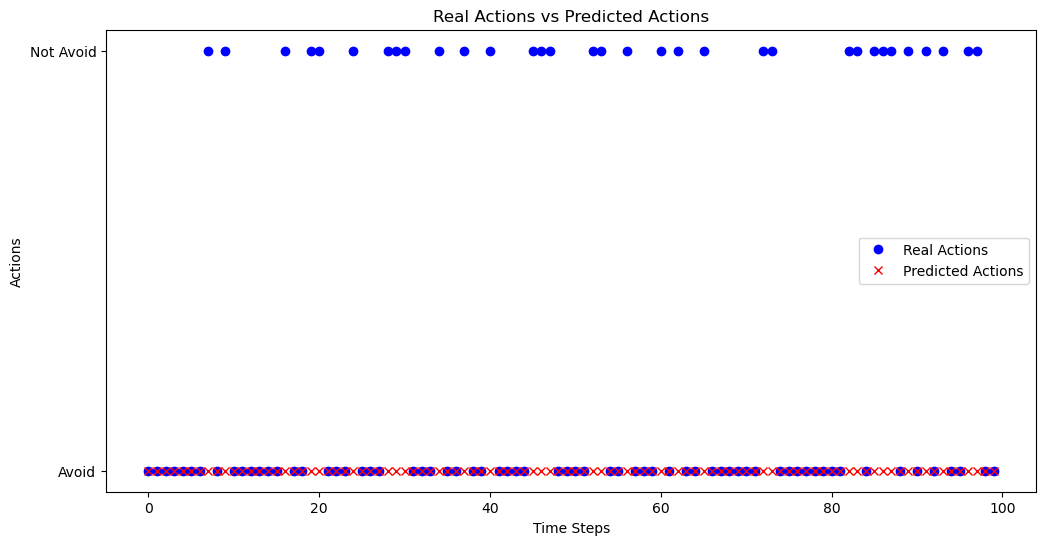

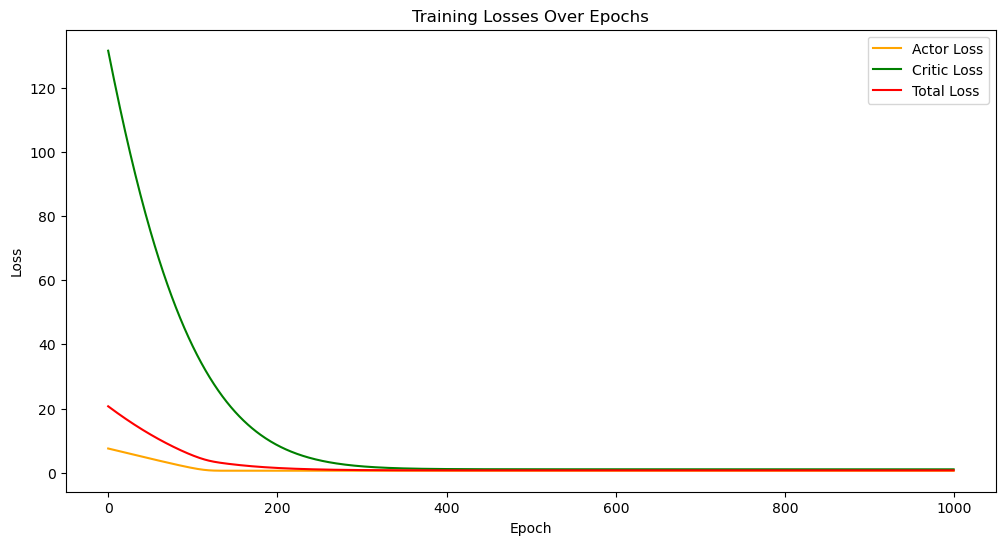

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Simulate animal behavior in active avoidance learning
def simulate_animal_behavior(num_steps):
    # Example: Simulate binary actions (0 = avoid, 1 = not avoid)
    # Real behavior: Animal avoids with some probability
    avoid_probability = 0.7  # Probability of avoiding
    real_actions = np.random.choice([0, 1], size=num_steps, p=[avoid_probability, 1 - avoid_probability])
    return real_actions

# Define the actor-critic model
class ActorCriticModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ActorCriticModel, self).__init__()
        self.actor_fc = nn.Linear(input_size, output_size)  # Outputs logits for actions
        self.critic_fc = nn.Linear(input_size, 1)  # Outputs value function

    def forward(self, x):
        actor_logits = self.actor_fc(x)  # Logits for action probabilities
        critic_value = self.critic_fc(x)  # Estimated value function
        return actor_logits, critic_value

# Initialize model, optimizer, and loss functions
input_size = 1  # Input feature size (e.g., state representation)
output_size = 2  # Two actions: avoid (0) or not avoid (1)
model = ActorCriticModel(input_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # For critic loss
action_criterion = nn.CrossEntropyLoss()  # For actor loss (classification)

# Simulate real animal behavior
num_steps = 100
real_actions = simulate_animal_behavior(num_steps)

# Prepare inputs (states) and targets (real actions)
# Example: Inputs are time steps (can be replaced with state features)
inputs = torch.FloatTensor(np.arange(num_steps).reshape(-1, 1))
targets = torch.LongTensor(real_actions)  # Actions are integers (0 or 1)

# Training loop
num_epochs = 1000
actor_losses = []
critic_losses = []
total_losses = []
predicted_actions = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    actor_logits, critic_values = model(inputs)
    
    # Actor loss: Cross-entropy between predicted and real actions
    actor_loss = action_criterion(actor_logits, targets)
    
    # Critic loss: Temporal Difference (TD) error
    # For simplicity, assume rewards are +1 for avoid (0) and -1 for not avoid (1)
    rewards = torch.where(targets == 0, 1.0, -1.0).unsqueeze(1)  # Reward for each action
    td_error = rewards - critic_values  # TD error
    critic_loss = criterion(critic_values, rewards)
    
    # Regularize actor loss with TD error
    regularization_lambda = 0.1
    total_loss = actor_loss + regularization_lambda * critic_loss
    
    # Backpropagation
    total_loss.backward()
    optimizer.step()
    
    # Store losses
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    total_losses.append(total_loss.item())
    
    # Store predicted actions
    predicted_actions.append(torch.argmax(actor_logits, dim=1).numpy())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.6f}")

# Get final predicted actions
final_predicted_actions = predicted_actions[-1]

# Plot real actions vs predicted actions
plt.figure(figsize=(12, 6))
plt.plot(real_actions, label="Real Actions", color='blue', marker='o', linestyle='None')
plt.plot(final_predicted_actions, label="Predicted Actions", color='red', marker='x', linestyle='None')
plt.xlabel("Time Steps")
plt.ylabel("Actions")
plt.title("Real Actions vs Predicted Actions")
plt.yticks([0, 1], ["Avoid", "Not Avoid"])
plt.legend()
plt.show()

# Plot training losses
plt.figure(figsize=(12, 6))
plt.plot(actor_losses, label="Actor Loss", color='orange')
plt.plot(critic_losses, label="Critic Loss", color='green')
plt.plot(total_losses, label="Total Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses Over Epochs")
plt.legend()
plt.show()

In [10]:
# Get final predicted actions
final_predicted_actions = predicted_actions[-1]

# Calculate the number of correct predictions
correct_predictions = np.sum(final_predicted_actions == real_actions)

# Calculate the percentage of correct predictions
accuracy = (correct_predictions / num_steps) * 100

# Print the accuracy
print(f"Percentage of Correct Predictions: {accuracy:.2f}%")

Percentage of Correct Predictions: 67.00%
